In [2]:
import torch
import torch.nn as nn 
import torch.optim as optim

import matplotlib.pyplot as plt 
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import seaborn as sns
from tools import BlindColours, zero_balanced_weights


(array([[ 0.19251367,  0.76027783,  0.79557895],
       [ 1.46338285,  0.44458514, -0.31049907],
       [-0.32177593,  0.43915889, -0.87408081]]), array([[-2.05376307e-01,  8.97710927e-02,  5.80868684e-01],
       [-2.87431673e-01, -1.36377397e+00,  4.16710491e-02],
       [-7.45397862e-01,  1.14310749e-03,  3.91991401e-01]]), array([[2.25188646, 0.        , 0.        ],
       [0.        , 1.18470544, 0.        ],
       [0.        , 0.        , 0.28843967]]), array([[5.67615383e-01, 3.33066907e-16, 3.33066907e-16],
       [3.33066907e-16, 5.67615383e-01, 1.43982049e-16],
       [3.33066907e-16, 1.43982049e-16, 5.67615383e-01]]))


In [7]:
from tools import zero_balanced_weights

## Step 1: Implementing a Two Layer Deep Linear Network in Pytorch

2. also have code to generate whitened inputs
3. generate balanced weights
4. make sure dynamics matches with QQt equations


In [3]:
in_dim = 5
hidden_dim = 3
out_dim = 4

learning_rate = 0.01


#THE NETWORK'S WEIGHTS ARE OPTIMISED WITH FULL BATCH GRADIENT DESCEINT WITH LEARNING RATE TAU

class LinearNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, init_w1=None, init_w2=None):
        super(LinearNetwork, self).__init__()
        self.first_layer = nn.Linear(in_dim, hidden_dim)
        self.second_layer = nn.Linear(hidden_dim , out_dim)

        if init_w1 is not None:
            self.first_layer.weight.data = init_w1.float()
        if init_w2 is not None:
            self.second_layer.weight.data = init_w2.float()

    def forward(self, x):
        x = self.first_layer(x)
        x = self.second_layer(x)
        return x 
    

def train(model, X_train, y_train, criterion, optimizer, epochs):
    
    w_ones = [model.first_layer.weight.data.clone()]
    w_twos = [model.second_layer.weight.data.clone()]
    losses = []

    for epoch in range(epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        w_ones.append(model.first_layer.weight.data.clone().numpy())
        w_twos.append(model.second_layer.weight.data.clone().numpy())
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    
    w_ones = np.array(w_ones)
    w_twos = np.array(w_twos)
    losses = np.array(losses)

    return w_ones, w_twos, losses

In [4]:
def whiten(X):

    scaler = StandardScaler()
    X_standardised = scaler.fit_transform(X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_standardised)

    X_whitened = torch.tensor(X_pca / np.sqrt(pca.explained_variance_), dtype=torch.float32)

    return X_whitened

def get_random_regression_task(batch_size, in_dim, out_dim):
    X = torch.randn(batch_size, in_dim)
    Y = torch.randn(batch_size, out_dim)
    X_whitened = whiten(X)
    if batch_size > 1:
        X_whitened = 1/np.sqrt(batch_size - 1) * X_whitened

    return X_whitened, Y

## Step 1.2: Implement Code for Balanced Weights

Balanced Condition: $W_1 W_1 ^ T - W_2^T W_2 = \lambda I$

Important Note: this method only works when hidden_dim $\leq$ min(in_dim, out_dim) due to properties of SVD. I still have to think about ways to extend this method to the general case.

### Algorithm Explained:

Let $X$ be a random matrice of dimensions (hidden_dim, hidden_dim)

$U S V^T = X$ (performing SVD)

$r = U V^T$

Now we initialise $W_1$, $W_2$ as random matrices of dimensions (hidden_dim, in_dim) and (out_dim, hidden_dim) respectively. They are also scaled by a parameter $\sigma$.

We define $\tilde{U} \tilde{S} \tilde{V}^T = W_2 W_1$

$\lambda = \frac{Tr(W_2 W_1)}{\text{hidden dim}}$

$S_2 = ...$ (reshaping so that it has the required shape) 

$S_1 = ...$ (reshaping so that it has the required shape)




In [5]:
def reshape_matrix(input_matrix, new_shape):

    old_shape = input_matrix.shape
    

    if new_shape[0] > old_shape[0]:

        new_matrix = np.vstack((input_matrix, np.zeros((new_shape[0] - old_shape[0], old_shape[1]))))
    elif new_shape[0] < old_shape[0]:

        new_matrix = input_matrix[:new_shape[0], :]
    else:
        new_matrix = input_matrix
    
    if new_shape[1] > old_shape[1]:
        new_matrix = np.hstack((new_matrix, np.zeros((new_shape[0], new_shape[1] - old_shape[1]))))
    elif new_shape[1] < old_shape[1]:
        new_matrix = new_matrix[:, :new_shape[1]]
    
    return new_matrix



def balanced_weights(in_dim, hidden_dim, out_dim):
    U, S, V = np.linalg.svd(np.random.randn(hidden_dim, hidden_dim))
    r = U @ V.T

    w1 = sigma * np.random.randn(hidden_dim, in_dim)
    w2 = sigma * np.random.randn(out_dim, hidden_dim)

    U_, S_, V_ = np.linalg.svd(w2 @ w1)
    s = np.sqrt(np.diag(S_))

    lmda = np.trace(w2 @ w1) / hidden_dim

    factor = (- lmda + np.sqrt(lmda ** 2 + 4 * s ** 2)) / 2

    s_2 = np.sqrt(np.diag(np.diag(factor)))

    s2_reshaped = reshape_matrix(s_2, (out_dim, hidden_dim))

    s_1 = np.diag(np.diag(s) / np.diag(s_2))

    s1_reshaped = reshape_matrix(s_1, (hidden_dim, in_dim))

    S_test = s2_reshaped @ s1_reshaped

    w1_out = r @ s1_reshaped @ V_.T 

    w2_out = U_ @ s2_reshaped @ r.T

    q = w1_out @ w1_out.T - w2_out.T @ w2_out

    scale_by = lmda / q[0][0]
    w1_out = scale_by * w1_out
    w2_out = scale_by * w2_out
    q = w1_out @ w1_out.T - w2_out.T @ w2_out

    return w1_out, w2_out, S_test, q

## Step 1.2 Implement Analytical Solution, Show that they Match for Balanced Weights

In [6]:
class QQT:
    def __init__(self, init_w1, init_w2, X, Y, weights_only=False):
        
        self.weights_only = weights_only
        self.batch_size = X.shape[0]

        self.input_dim = X.shape[1]
        self.output_dim = Y.shape[1]
        
        sigma_yx_tilde = 1 / self.batch_size * Y.T @ X 

        U_, S_, Vt_= np.linalg.svd(sigma_yx_tilde)
        V_ = Vt_.T 

        self.dim_diff = np.abs(self.input_dim - self.output_dim)

        if self.input_dim < self.output_dim:
            U_hat = U_[:, self.input_dim:]
            V_hat = np.zeros((self.input_dim, self.dim_diff))
            U_ = U_[:, :self.output_dim]

        elif self.input_dim > self.output_dim:
            U_hat = np.zeros((self.output_dim, self.dim_diff))
            V_hat = V_[:, self.output_dim:]
            V_ = V_[:, :self.output_dim]

        else:
            U_hat  = None 
            V_hat = None

        self.U_hat = U_hat 
        self.V_hat = V_hat 
        self.U_, self.S_, self.V_ = U_, np.diag(S_), V_

        U, S, Vt  = np.linalg.svd(init_w2 @ init_w1, full_matrices=False)
        self.U, self.S, self.V = U, S, Vt.T 

        self.B = self.U.T @ self.U_ + self.V.T @ self.V_ 
        self.C = self.U.T @ self.U_ - self.V.T @ self.V_



        ##CHECK THAT B IS NON SINGULAR
        self.t = 0

    def forward(self, learning_rate):
        #performs forward for one timestep

        time_step = self.t * learning_rate

        i = np.identity(self.input_dim) if self.input_dim < self.output_dim else np.identity(self.output_dim) 

        e_st_inv = np.diag(np.exp(-1 * np.diag(self.S_) * time_step))
        e_2st_inv = np.diag(np.exp(-2 * np.diag(self.S_) * time_step))

        B_inv = np.linalg.inv(self.B)

        Sinv = np.diag(1. / self.S)
        S_inv = np.diag(1. / self.S_)

        if self.U_hat is None and self.V_hat is None:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv),
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv)
            ])
            center_right = 0.

        else:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.V_hat@self.V_hat.T @ self.V @ B_inv.T @ e_st_inv,
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.U_hat@self.U_hat.T @ self.U @ B_inv.T @ e_st_inv
            ])
            center_right = 4 * time_step * e_st_inv @ B_inv @ (self.V.T @ self.V_hat @ self.V_hat.T @ self.V + self.U.T @ self.U_hat @ self.U_hat.T @ self.U) @ B_inv.T @ e_st_inv

        center_left = 4. * e_st_inv @ B_inv @ Sinv @ B_inv.T @ e_st_inv 
        center_center = (i - e_2st_inv) @ S_inv- e_st_inv @ B_inv @ self.C @ (e_2st_inv - i) @ S_inv @ self.C.T @ B_inv.T @ e_st_inv

        center = np.linalg.inv(center_left + center_center + center_right)

        qqt = Z @ center @ Z.T 
        if self.weights_only:
            qqt = qqt[self.input_dim:, :self.input_dim] 

        self.t+=1
        return qqt 

Epoch [10/5000], Loss: 0.6450
Epoch [20/5000], Loss: 0.6301
Epoch [30/5000], Loss: 0.6192
Epoch [40/5000], Loss: 0.6111
Epoch [50/5000], Loss: 0.6049
Epoch [60/5000], Loss: 0.6000
Epoch [70/5000], Loss: 0.5960
Epoch [80/5000], Loss: 0.5926
Epoch [90/5000], Loss: 0.5897
Epoch [100/5000], Loss: 0.5871
Epoch [110/5000], Loss: 0.5848
Epoch [120/5000], Loss: 0.5826
Epoch [130/5000], Loss: 0.5806
Epoch [140/5000], Loss: 0.5786
Epoch [150/5000], Loss: 0.5768
Epoch [160/5000], Loss: 0.5750
Epoch [170/5000], Loss: 0.5732
Epoch [180/5000], Loss: 0.5715
Epoch [190/5000], Loss: 0.5698
Epoch [200/5000], Loss: 0.5682
Epoch [210/5000], Loss: 0.5666
Epoch [220/5000], Loss: 0.5651
Epoch [230/5000], Loss: 0.5635
Epoch [240/5000], Loss: 0.5620
Epoch [250/5000], Loss: 0.5605
Epoch [260/5000], Loss: 0.5590
Epoch [270/5000], Loss: 0.5576
Epoch [280/5000], Loss: 0.5561
Epoch [290/5000], Loss: 0.5547
Epoch [300/5000], Loss: 0.5533
Epoch [310/5000], Loss: 0.5519
Epoch [320/5000], Loss: 0.5505
Epoch [330/5000],

/var/folders/x9/316v313n6_g8y8_p7fz_v6cw0000gn/T/ipykernel_10897/1962039545.py:59: RuntimeWarning: divide by zero encountered in divide
  S_inv = np.diag(1. / self.S_)


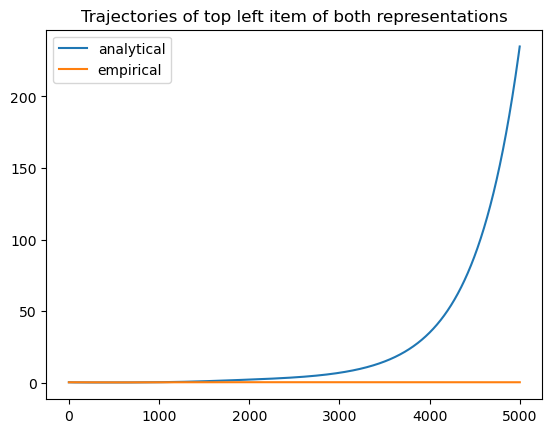

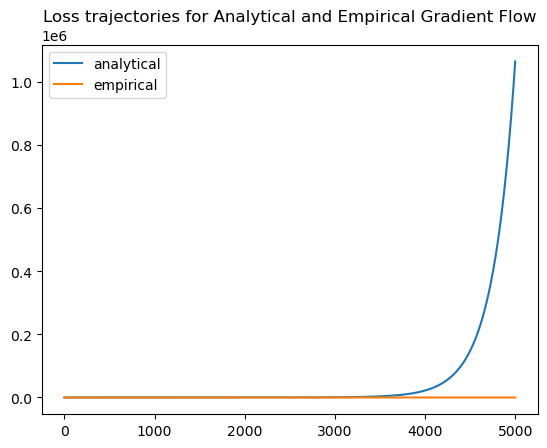

In [14]:
in_dim = 5
hidden_dim = 10
out_dim = 2

tau = 0.01
batch_size = 10
epochs = 1000*5

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
init_w1 = torch.tensor(init_w1)
init_w2 = torch.tensor(init_w2)

model = LinearNetwork(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1, init_w2=init_w2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=tau)

X_train, Y_train = get_random_regression_task(batch_size, in_dim, out_dim)

w1s, w2s, losses = train(model, X_train, Y_train, criterion, optimizer, epochs)

analytical = QQT(init_w1, init_w2, X_train, Y_train, True)
analytical = np.asarray([analytical.forward(tau) for _ in range(epochs)])

w2w1s = [w2 @ w1 for (w2, w1) in zip(w2s, w1s)]
diffs = [np.linalg.norm(w2w1 - anal) for (w2w1, anal) in zip(w2w1s, analytical)]


top_left_empirical = [w2w1[0][0] for w2w1 in w2w1s]
top_left_analytical = [anal[0][0] for anal in analytical]



#TODO plot trajectories of N items
plt.plot(top_left_analytical, label='analytical')
plt.plot(top_left_empirical, label='empirical')
plt.title('Trajectories of top left item of both representations')
plt.legend()
plt.show()

anal_loss = np.linalg.norm(X_train @ torch.tensor(analytical[-1]).float().T - Y_train)
emp_loss = np.linalg.norm(X_train @ torch.tensor(w2w1s[-1]).T - Y_train)



output_analytical = [(X_train) @ torch.tensor(anal).float().T for anal in analytical]
output_empirical = [(X_train) @ torch.tensor(w2w1).float().T for w2w1 in w2w1s]

losses_empirical = [0.5 * out_dim / batch_size * np.linalg.norm(out - Y_train)**2 for out in output_empirical]
losses_analytical = [0.5 * out_dim / batch_size * np.linalg.norm(out - Y_train)**2 for out in output_analytical]


plt.plot(losses_analytical, label='analytical')
plt.plot(losses_empirical, label='empirical')
plt.title('Loss trajectories for Analytical and Empirical Gradient Flow')
plt.legend()
plt.show()


##maybe transpose wrong?

In [275]:
losses_analytical[-1]

0.47091679573059086

## Step 1.2

STILL HAVE TO PLOT THE TRAJECTOREIS FOR MULTIPLE ITEMS, BUT I THINK THEY SHOULD MATCH BASED ON THE LOSS CURVE AND THE NORM OF THE DIFFERENCE OF THE REPRESENTATIONS

## Step 2: Plotting Empirical Forgetting and Rate of Forgetting

HOW DO WE DEFINE FORGETTTING? EXPLAIN HERE

We have three tasks: $T_i, T_j, T_k$ which we are learning in alphabetical order. We define $F_i(T_j, T_k)$ as how much we forget about $T_i$ while learning $T_k$, compared to how much we knew after having just learned $T_j$

In [79]:
tau = 0.1
batch_size = 10
epochs = 400

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
init_w1 = torch.tensor(init_w1)
init_w2 = torch.tensor(init_w2)

model = LinearNetwork(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1, init_w2=init_w2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=tau)

num_tasks = 3

tasks = [get_random_regression_task(batch_size, in_dim, out_dim) for _ in range(num_tasks)]

w1s_list = []
w2s_list = []

for (X, Y) in tasks:
    w1s, w2s, _ = train(model, X, Y, criterion, optimizer, epochs)
    w1s_list.extend(w1s)
    w2s_list.extend(w2s)


w2w1s_list = [w2 @ w1 for (w2, w1) in zip(w2s_list, w1s_list)]
#now just have a list of losses, plot losses

losses_list = []

for i, (X, Y) in enumerate(tasks):
    output_empirical = [X @ w2w1.T for w2w1 in w2w1s_list]
    losses = [0.5 * out_dim / batch_size * np.linalg.norm(out - Y) for out in output_empirical]
    losses_list.append(losses)

losses_list = torch.tensor(losses_list)


#plot forgetting based off definition


Epoch [10/400], Loss: 0.6951
Epoch [20/400], Loss: 0.5178
Epoch [30/400], Loss: 0.4333
Epoch [40/400], Loss: 0.3886
Epoch [50/400], Loss: 0.3617
Epoch [60/400], Loss: 0.3459
Epoch [70/400], Loss: 0.3369
Epoch [80/400], Loss: 0.3309
Epoch [90/400], Loss: 0.3256
Epoch [100/400], Loss: 0.3196
Epoch [110/400], Loss: 0.3130
Epoch [120/400], Loss: 0.3059
Epoch [130/400], Loss: 0.2993
Epoch [140/400], Loss: 0.2938
Epoch [150/400], Loss: 0.2899
Epoch [160/400], Loss: 0.2875
Epoch [170/400], Loss: 0.2860
Epoch [180/400], Loss: 0.2852
Epoch [190/400], Loss: 0.2848
Epoch [200/400], Loss: 0.2846
Epoch [210/400], Loss: 0.2845
Epoch [220/400], Loss: 0.2844
Epoch [230/400], Loss: 0.2844
Epoch [240/400], Loss: 0.2844
Epoch [250/400], Loss: 0.2843
Epoch [260/400], Loss: 0.2843
Epoch [270/400], Loss: 0.2843
Epoch [280/400], Loss: 0.2843
Epoch [290/400], Loss: 0.2843
Epoch [300/400], Loss: 0.2843
Epoch [310/400], Loss: 0.2843
Epoch [320/400], Loss: 0.2843
Epoch [330/400], Loss: 0.2843
Epoch [340/400], Lo

Text(0.5, 1.0, 'Losses for First Tasks through Training')

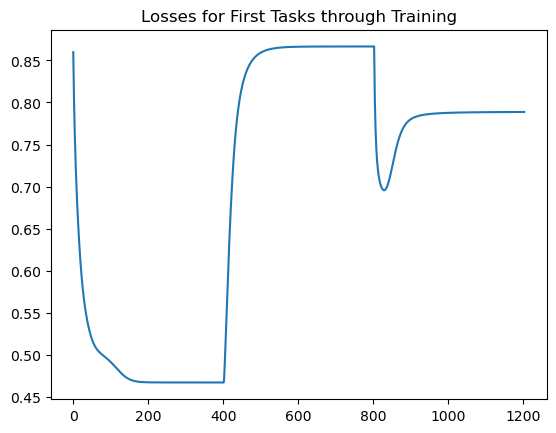

In [86]:
plt.plot(losses_list[0])
plt.title('Losses for First Tasks through Training')

Text(0.5, 1.0, 'Losses for second task through Training')

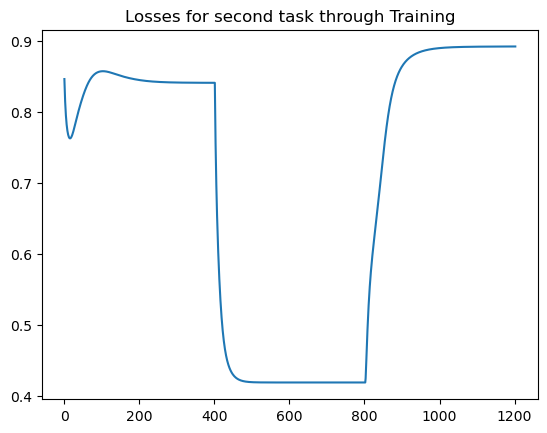

In [87]:
plt.plot(losses_list[1])
plt.title('Losses for second task through Training')

Text(0.5, 1.0, 'Losses for third task through training')

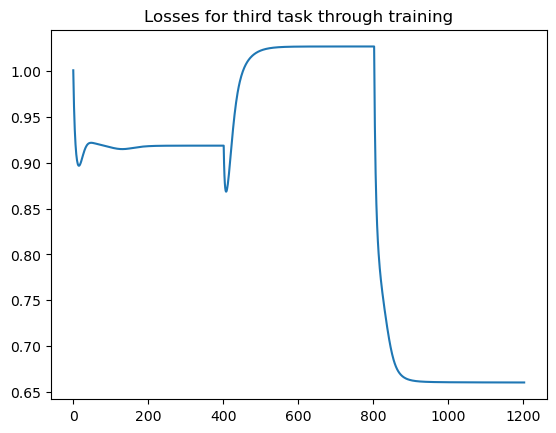

In [88]:
plt.plot(losses_list[2])
plt.title('Losses for third task through training')

## Step 2.2: Code for Empirical Forgetting + Empirical Rate of Forgetting

Text(0.5, 1.0, 'Empirical Forgetting')

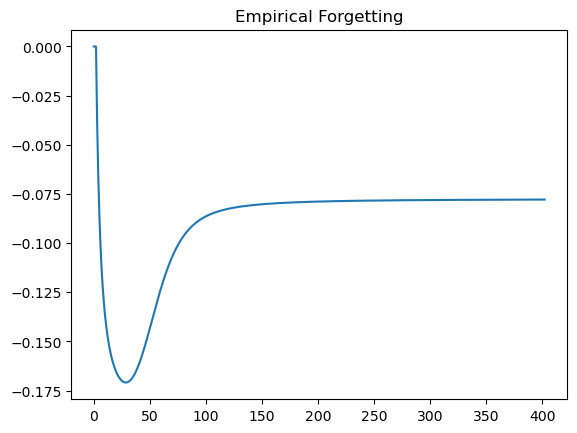

In [91]:
### add this here

#Calculating Forgetting of first task while performing task 3

forgetting = losses_list[0][2 * epochs:] - losses_list[0][2*epochs]

plt.plot(forgetting)
plt.title('Empirical Forgetting')

In [93]:
def calculate_derivative(time_series, time_step):
    derivative = np.diff(time_series) / time_step
    return derivative

Text(0.5, 1.0, 'Rate of Forgetting Plot')

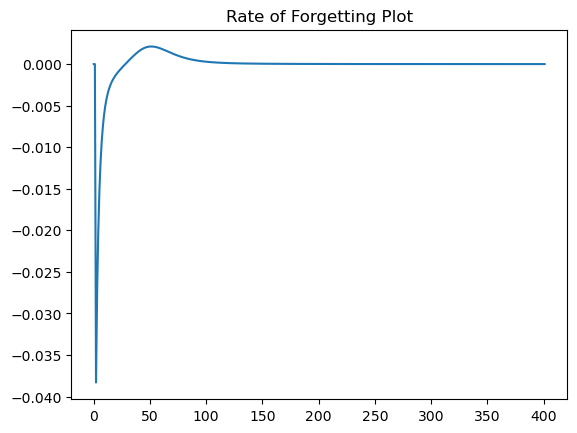

In [95]:
forgetting_rate = calculate_derivative(forgetting, 1)

plt.plot(forgetting_rate)
plt.title('Rate of Forgetting Plot')

## Step 3: Plotting Analytical Forgetting in the two forms, check that it matches with results

We consider the case of training a two-layer deep linear network on a sequence of tasks $T_a = ...$, $T_b = ...$. Then the full batch loss of the $i$-th task at any point in training time is:

$L_i = \frac{1}{2 P} || W_2 W_1 X_i - Y_i ||^2_{F}$

We know from earlier results in the paper that after training the network to convergence on task $T_j$ the network function is $W_2 W_1 = \tilde{U} \tilde {S} \tilde{V} ^T = \tilde{\Sigma}^{yx}_j$

Hence UNDER THE ASSUMPTION OF WHITENED INPUTS, with P = batch size the full batch loss is given by:

$L_i = \frac{1}{2 P} || \tilde{\Sigma}^{yx}_j X_i - Y_i ||^2_{F}$

$ = \frac{1}{2 P} Tr((\tilde{\Sigma}^{yx}_j X_i - Y_i)(\tilde{\Sigma}^{yx}_j X_i - Y_i)^T)$

$= \frac{1}{2 P} Tr(\tilde{\Sigma}^{yx}_j X_i X_i ^ T(\tilde{\Sigma}^{yx}_j)^T) - \frac{1}{P}Tr(\tilde{\Sigma}^{yx}_j X_i Y_i^T) + \frac{1}{2P} Tr(Y_i Y_i^T)$

Using Whitened Inputs assumption

$= \frac{1}{2 P} Tr(\tilde{\Sigma}^{yx}_j (\tilde{\Sigma}^{yx}_j)^T) - \frac{1}{P}Tr(\tilde{\Sigma}^{yx}_j (\tilde{\Sigma}^{yx}_i)^T) + \frac{1}{2P} Tr((\tilde{\Sigma}^{yy}_i)$


$ = \frac{1} {2 P} Tr((\tilde{\Sigma}^{yx}_j - \tilde{\Sigma}^{yx}_i) (\tilde{\Sigma}^{yx}_j - \tilde{\Sigma}^{yx}_i)^T - \tilde{\Sigma}^{yx}_i (\tilde{\Sigma}^{yx}_i)^T) + \frac{1}{2P} Tr((\tilde{\Sigma}^{yy}_i)$


$ = \frac{1}{2 P} ||\tilde{\Sigma}^{yx}_j - \tilde{\Sigma}^{yx}_i||_F ^ 2 - \frac{1}{2 P} Tr((\tilde{\Sigma}^{yx}_i) (\tilde{\Sigma}^{yx}_i)^T) + \frac{1}{2P} Tr(\tilde{\Sigma}^{yy}_i)$

$ = \frac{1}{2 P} ||\tilde{\Sigma}^{yx}_j - \tilde{\Sigma}^{yx}_i||_F ^ 2 - \frac{1}{2 P} ||\tilde{\Sigma}^{yx}_i||_F^2 + \frac{1}{2 P} || Y_i||^2_F $


Notice that only the first term depends on task $j$, the new task we are learning. All the other terms depend solely on task $i$

We group the temrs that only depend ont Task $i$ and call them $c$. 

Using this result, we can derive a new formula for the Forgetting between two tasks.

$ F_i(T_j, T_k) = L_i(T_k) - L_i(T_j)$ CHECK THIS DEFINITION WORKS

$= \frac{1}{2 P} ||\tilde{\Sigma}^{yx}_k - \tilde{\Sigma}^{yx}_i||_F ^ 2 + c - \frac{1}{2 P} ||\tilde{\Sigma}^{yx}_j - \tilde{\Sigma}^{yx}_i|| - c$

$ F_i(T_j, T_k) = \frac{1}{2 P} (||\tilde{\Sigma}^{yx}_k - \tilde{\Sigma}^{yx}_i|| - ||\tilde{\Sigma}^{yx}_j - \tilde{\Sigma}^{yx}_i||)$ CHECK THIS DEFINITION WORKS






FIRST ANALYTICAL FORGETTING FORMULA - FUNCTION OF THE LOSSES

In [332]:
#this is a function of the losses

#do analytical = ...
#analytical.forward 
#next set the model weights to what they should be
#analytical.forward again

in_dim = 4
hidden_dim = 3
out_dim = 5

tau = 0.1
batch_size = 10
epochs = 400

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
init_w1 = torch.tensor(init_w1)
init_w2 = torch.tensor(init_w2)

model = LinearNetwork(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1, init_w2=init_w2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=tau)

num_tasks = 3

tasks = [get_random_regression_task(batch_size, in_dim, out_dim) for _ in range(num_tasks)]

w1s_list = []
w2s_list = []

for (X, Y) in tasks:
    w1s, w2s, _ = train(model, X, Y, criterion, optimizer, epochs)
    w1s_list.extend(w1s)
    w2s_list.extend(w2s)

analyticals_list = []

for i, (X, Y) in enumerate(tasks):
    w1_0 = w1s_list[epochs * i]
    w2_0 = w2s_list[epochs * i]
    analytical = QQT(w1_0, w2_0, X.T, Y.T, True)
    analytical = np.asarray([analytical.forward(tau) for _ in range(epochs)])
    analyticals_list.extend(analytical)


empirical_losses = []

for i, (X, Y) in enumerate(tasks):
    output_empirical = [X @ w2w1.T for w2w1 in w2w1s_list]
    losses = [0.5 * out_dim / batch_size * np.linalg.norm(out - Y, ord='fro')**2 for out in output_empirical]
    empirical_losses.append(losses)

empirical_losses = torch.tensor(losses_list)


analytical_losses = []

for i, (X, Y) in enumerate(tasks):
    output_analytical = [X @ analytical.T for analytical in analyticals_list]
    losses = [0.5 * out_dim / batch_size * np.linalg.norm(out - Y, ord='fro')**2 for out in output_analytical]
    analytical_losses.append(losses)

analytical_losses = torch.tensor(losses_list)


plt.plot(analytical_losses[0])
plt.plot(empirical_losses[0])
plt.show()


ValueError: negative dimensions are not allowed

Text(0.5, 1.0, 'Empirical vs Analytical Forgetting')

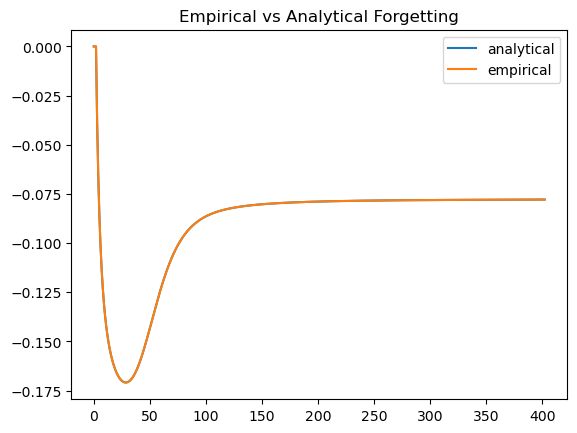

In [290]:
forgetting_analytical = analytical_losses[0][2 * epochs:] - analytical_losses[0][2*epochs]

forgetting_empirical = empirical_losses[0][2 * epochs:] - empirical_losses[0][2*epochs]

forgetting = losses_list[0][2 * epochs:] - losses_list[0][2*epochs]

plt.plot(forgetting_analytical, label='analytical')
plt.plot(forgetting_empirical, label='empirical')
plt.legend()
plt.title('Empirical vs Analytical Forgetting')

### Step 3.2: Check that the analytical formula for loss works

In [134]:
analytical_losses

tensor([[0.8598, 0.8288, 0.8032,  ..., 0.7887, 0.7887, 0.7887],
        [0.8467, 0.8289, 0.8151,  ..., 0.8926, 0.8926, 0.8926],
        [1.0008, 0.9784, 0.9610,  ..., 0.6603, 0.6603, 0.6603]],
       dtype=torch.float64)

## CHECK THAT IT WORKS FOR THE LOSSES FIRST

Epoch [10/400], Loss: 0.8975
Epoch [20/400], Loss: 0.8410
Epoch [30/400], Loss: 0.7871
Epoch [40/400], Loss: 0.7350
Epoch [50/400], Loss: 0.6871
Epoch [60/400], Loss: 0.6463
Epoch [70/400], Loss: 0.6146
Epoch [80/400], Loss: 0.5916
Epoch [90/400], Loss: 0.5760
Epoch [100/400], Loss: 0.5655
Epoch [110/400], Loss: 0.5584
Epoch [120/400], Loss: 0.5533
Epoch [130/400], Loss: 0.5494
Epoch [140/400], Loss: 0.5463
Epoch [150/400], Loss: 0.5435
Epoch [160/400], Loss: 0.5410
Epoch [170/400], Loss: 0.5387
Epoch [180/400], Loss: 0.5365
Epoch [190/400], Loss: 0.5344
Epoch [200/400], Loss: 0.5324
Epoch [210/400], Loss: 0.5305
Epoch [220/400], Loss: 0.5286
Epoch [230/400], Loss: 0.5268
Epoch [240/400], Loss: 0.5251
Epoch [250/400], Loss: 0.5235
Epoch [260/400], Loss: 0.5219
Epoch [270/400], Loss: 0.5204
Epoch [280/400], Loss: 0.5190
Epoch [290/400], Loss: 0.5177
Epoch [300/400], Loss: 0.5164
Epoch [310/400], Loss: 0.5152
Epoch [320/400], Loss: 0.5140
Epoch [330/400], Loss: 0.5129
Epoch [340/400], Lo

/var/folders/x9/316v313n6_g8y8_p7fz_v6cw0000gn/T/ipykernel_51183/1629971777.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma_yx_i = torch.tensor(Y_i.T @ X_i)
/var/folders/x9/316v313n6_g8y8_p7fz_v6cw0000gn/T/ipykernel_51183/1629971777.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma_yy_i = torch.tensor(Y_i @ Y_i.T)


[]

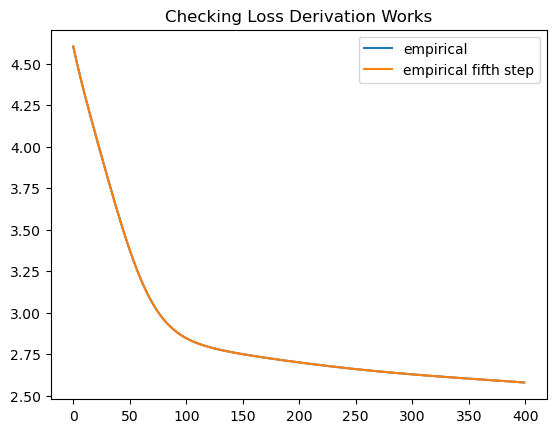

In [331]:
in_dim = 4
hidden_dim = 5
out_dim = 3

tau = 0.1
batch_size = 10
epochs = 400

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
init_w1 = torch.tensor(init_w1)
init_w2 = torch.tensor(init_w2)

model = LinearNetwork(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1, init_w2=init_w2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=tau)

num_tasks = 3

tasks = [get_random_regression_task(batch_size, in_dim, out_dim) for _ in range(num_tasks)]

w1s_list = []
w2s_list = []

for (X, Y) in tasks:
    w1s, w2s, _ = train(model, X, Y, criterion, optimizer, epochs)
    w1s_list.extend(w1s)
    w2s_list.extend(w2s)


losses_empirical_i = empirical_losses[0][:400]
w1s_empirical = w1s_list[:400]
w2s_empirical = w2s_list[:400]
w2w1s_empirical = [torch.tensor(w2@w1) for (w2, w1) in zip(w2s_empirical, w1s_empirical)]

(X_i, Y_i) = tasks[0]

sigma_yx_i = torch.tensor(Y_i.T @ X_i)
sigma_yy_i = torch.tensor(Y_i @ Y_i.T)

losses_empirical_i = [0.5 * out_dim / batch_size * np.linalg.norm((X_i @ w2w1.T - Y_i), ord='fro')**2 for w2w1 in w2w1s_empirical]
losses_v1 = [0.5 * out_dim / batch_size * np.trace((X_i @ sigma_j.T - Y_i) @ (X_i @ sigma_j.T - Y_i).T) for sigma_j in w2w1s_empirical]
losses_v2 = [0.5 * out_dim / batch_size * np.trace(X_i @ sigma_j.T @ sigma_j @ X_i.T - Y_i @ sigma_j @ X_i.T - X_i @ sigma_j.T @ Y_i.T + Y_i @ Y_i.T) for sigma_j in w2w1s_empirical]



##TODO fix how we initialise the (X, Y), should work after that

losses_v3 = [0.5 * out_dim / batch_size * (np.trace(sigma_j @ sigma_j.T) - 2 * np.trace(sigma_j @ sigma_yx_i.T) + np.trace(sigma_yy_i)) for sigma_j in w2w1s_empirical]




losses_v4 = [0.5 * out_dim / batch_size * (np.trace((sigma_j - sigma_yx_i) @ (sigma_j - sigma_yx_i).T - sigma_yx_i @ sigma_yx_i.T) + np.trace(sigma_yy_i)) for sigma_j in w2w1s_empirical]
losses_v5 = [0.5 * out_dim / batch_size * (np.linalg.norm(sigma_j - sigma_yx_i, ord='fro')**2 - np.trace(sigma_yx_i @ sigma_yx_i.T) + np.trace(sigma_yy_i)) for sigma_j in w2w1s_empirical]


plt.plot(losses_empirical_i, label = 'empirical')
plt.title('Checking Loss Derivation Works')
plt.plot(losses_v5, label = 'empirical fifth step')
plt.legend()
plt.plot()

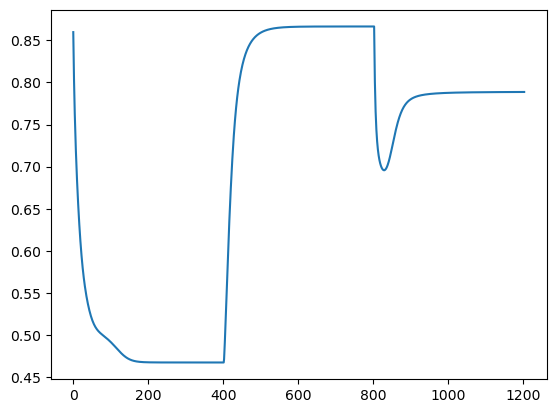

In [334]:
plt.plot(empirical_losses[0])

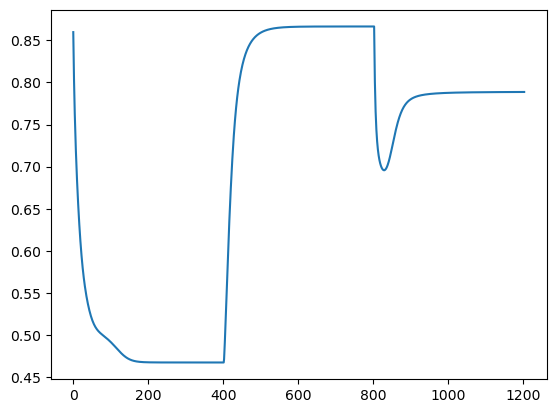

In [335]:
plt.plot(analytical_losses[0])

CHECK THAT IT WORKS FOR FORGETTING



/var/folders/x9/316v313n6_g8y8_p7fz_v6cw0000gn/T/ipykernel_51183/945849366.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma_yx_i = torch.tensor(Y_i.T @ X_i)
/var/folders/x9/316v313n6_g8y8_p7fz_v6cw0000gn/T/ipykernel_51183/945849366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma_yx_j = torch.tensor(Y_j.T @ X_j)


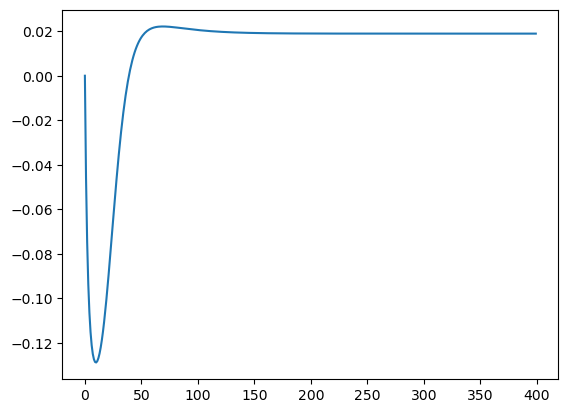

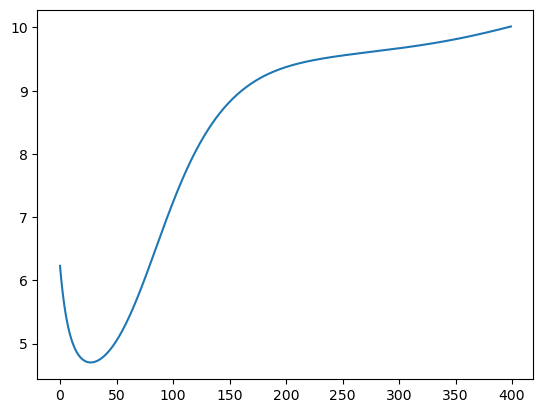

In [342]:
sigma_i = analyticals_list[epochs*1]
sigma_j = analyticals_list[epochs*2]

forgetting_analytical_2 =  [0.5 *out_dim/ batch_size * (np.linalg.norm(anal - sigma_i, ord='fro')**2 - np.linalg.norm(sigma_j - sigma_i, ord='fro')**2) for anal in analyticals_list[epochs*2:]]


w1s_empirical = w1s_list[-400:]
w2s_empirical = w2s_list[-400:]
w2w1s_empirical = [torch.tensor(w2@w1) for (w2, w1) in zip(w2s_empirical, w1s_empirical)]

(X_i, Y_i) = tasks[0]
(X_j, Y_j) = tasks[0]

sigma_yx_i = torch.tensor(Y_i.T @ X_i)
sigma_yx_j = torch.tensor(Y_j.T @ X_j)

forgetting = [0.5 * out_dim / batch_size * (np.linalg.norm(sigma_k - sigma_yx_i, ord='fro')**2 - np.linalg.norm(sigma_yx_j - sigma_yx_i)**2) for sigma_k in w2w1s_empirical]

plt.plot(forgetting_analytical_2)
plt.show()
plt.plot(forgetting)


In [ ]:
##okay this now works, now try with forgetting

#this is just a function of the weights

sigma_i = analyticals_list[epochs*1]
sigma_j = analyticals_list[epochs*2]

forgetting_analytical_2 =  [0.5 *out_dim/ batch_size * (np.linalg.norm(anal - sigma_i, ord='fro')**2 - np.linalg.norm(sigma_j - sigma_i, ord='fro')**2) for anal in analyticals_list[epochs*2:]]

# forgetting_analytical_2
# plt.plot(forgetting_analytical_2)

plt.plot(forgetting_analytical_2, label='analytical 2')
plt.plot(forgetting_empirical, label='empirical')
plt.legend()
plt.title('Empirical vs Analytical Forgetting')


##implement this for unbalanced weights
#extend this to unbalanced 
#we have a derivation for forgetting in the unbalanced case

#if it does converge and it is full rank 
#only train on one example it can converge but many of the weights will be unused

#exact dynamics across time for forgetting

#in two layers you are guaranteed to converge 




In [315]:
print(X_i.T @ X_i)

X_i.shape

tensor([[ 9.0000e+00, -1.2201e-07,  1.7691e-08,  1.0368e-07],
        [-1.2201e-07,  9.0000e+00,  5.5258e-08, -7.3441e-08],
        [ 1.7691e-08,  5.5258e-08,  9.0000e+00,  1.5156e-07],
        [ 1.0368e-07, -7.3441e-08,  1.5156e-07,  9.0000e+00]])


torch.Size([10, 4])

In [320]:
(X, Y) = get_random_regression_task(in_dim = 3, out_dim=4, batch_size=7)

X.T @ X

tensor([[ 6.0000e+00, -7.2901e-08,  1.9038e-08],
        [-7.2901e-08,  6.0000e+00,  7.5697e-08],
        [ 1.9038e-08,  7.5697e-08,  6.0000e+00]])

In [299]:
print('X: ', X_i.shape)
print('Y: ', Y_i.shape)
print('sigma: ', w2w1s_empirical[0].shape)
print('w1: ', w1s_empirical[0].shape)
print('w2: ', w2s_empirical[0].shape)

X:  torch.Size([10, 4])
Y:  torch.Size([10, 3])
sigma:  (3, 4)
w1:  (5, 4)
w2:  (3, 5)


In [281]:
len(losses_empirical_i)

1203

In [ ]:
#check that it works for 

EXCEPT FOR THE WHITENING STEP, THIS WORKS

/var/folders/x9/316v313n6_g8y8_p7fz_v6cw0000gn/T/ipykernel_51183/3196529144.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  analyticals_list = [torch.tensor(anal).float() for anal in analyticals_list]


[]

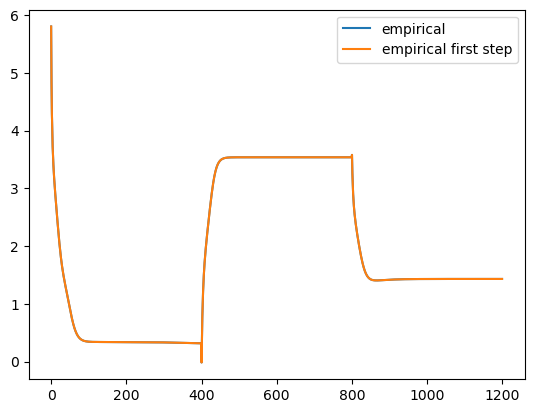

In [203]:
analytical_losses_i = analytical_losses[0]

X, Y = tasks[0]

analyticals_list = [torch.tensor(anal).float() for anal in analyticals_list]

output_analytical = [X @ analytical.T for analytical in analyticals_list]
losses_v1 = [0.5 * out_dim / batch_size * np.linalg.norm(out - Y, ord='fro')**2 for out in output_analytical]
# losses = [0.5 * out_dim / batch_size * np.linalg.norm(X @ anal.T - Y, ord='fro')**2 for anal in analyticals_list]
losses = [0.5 * out_dim / batch_size * np.trace((anal @ X.T - Y.T) @ (anal @ X.T - Y.T).T) for anal in analyticals_list]

losses = [0.5 * out_dim / batch_size * (np.trace(anal @ X.T @ X @ anal.T) - 2 * np.trace(anal @ X.T @ Y) + np.trace(Y.T @ Y)) for anal in analyticals_list]


#TODO for some reason X is not whitened properly here
losses_v2 = [0.5 * out_dim / batch_size * (np.trace(anal @ anal.T) - 2 * np.trace(anal @ X.T @ Y) + np.trace(Y.T @ Y)) for anal in analyticals_list]

# losses = [0.5 * out_dim / batch_size * (np.trace((anal.T - X.T @ Y) @ (anal.T  - X.T @ Y).T - X.T @ Y @ Y.T @ X) + np.trace(Y@Y.T)) for anal in analyticals_list]

losses = [0.5 * out_dim / batch_size * (np.linalg.norm(anal.T - X.T @ Y, ord='fro')**2 - np.trace(X.T @ Y @ Y.T @ X) + np.trace(Y @ Y.T)) for anal in analyticals_list]



# losses = [0.5 * out_dim / batch_size * (np.trace(anal.T @ anal) - 2 * np.trace(anal @ X.T @ Y) + np.trace(Y @ Y.T)) for anal in analyticals_list]

# losses = [np.trace(anal.T @ anal) - 2 * np.trace(anal @ X.T @ Y) + np.trace(Y @ Y.T) for anal in analyticals_list]


plt.plot(losses, label = 'empirical')
plt.plot(losses_v2, label = 'empirical first step')
plt.legend()
plt.plot()

In [204]:
losses[0]

5.803809329400383

In [196]:
anal.T - X.T @ Y

tensor([[ 0.4576,  5.7540,  1.8553],
        [-0.0977,  3.2470,  1.2754],
        [ 3.9746, -0.7575,  6.7343],
        [-2.7412,  0.7539, -2.5621]], dtype=torch.float64)

In [192]:
(anal@anal.T).shape

torch.Size([3, 3])

In [193]:
(X.T @ Y).shape

torch.Size([4, 3])

In [182]:
X.T @ X / batch_size

tensor([[ 9.0000e-01,  7.1450e-09, -2.4001e-09,  1.0157e-08],
        [ 7.1450e-09,  9.0000e-01,  1.4902e-08,  1.9160e-09],
        [-2.4001e-09,  1.4902e-08,  9.0000e-01, -8.3414e-09],
        [ 1.0157e-08,  1.9160e-09, -8.3414e-09,  9.0000e-01]])

In [169]:
 [out_dim / batch_size * np.trace(X @ anal.T @ anal @ X.T) - 2 * np.trace(X @ anal.T.float() @ Y.T) + np.trace(Y @ Y.T) for anal in analyticals_list]

[43.98233833312988,
 34.85105247497559,
 30.27411298751831,
 27.521072816848754,
 25.659831070899962,
 24.29502026438713,
 23.22746225595474,
 22.34670548439026,
 21.58804647922516,
 20.912041854858398,
 20.29153550863266,
 19.706094241142274,
 19.148207020759582,
 18.608237290382384,
 18.081572794914244,
 17.565485191345214,
 17.059863114356993,
 16.564164113998412,
 16.08086230754852,
 15.61006784439087,
 15.1555739402771,
 14.717244458198547,
 14.2981778383255,
 13.898341727256774,
 13.518364238739014,
 13.159463691711426,
 12.821198987960816,
 12.502749681472778,
 12.202723169326783,
 11.920415878295898,
 11.653660297393799,
 11.400770235061646,
 11.160073614120483,
 10.929852390289307,
 10.708041143417358,
 10.492968273162841,
 10.283481216430664,
 10.077559661865234,
 9.873988389968872,
 9.67208743095398,
 9.470650768280029,
 9.26927924156189,
 9.067467880249023,
 8.864852809906006,
 8.661458444595336,
 8.457525539398194,
 8.253435945510864,
 8.049499368667602,
 7.846333265304565

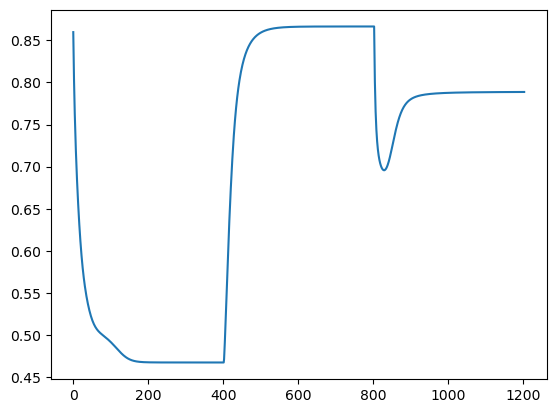

In [138]:
plt.plot(analytical_losses[0])

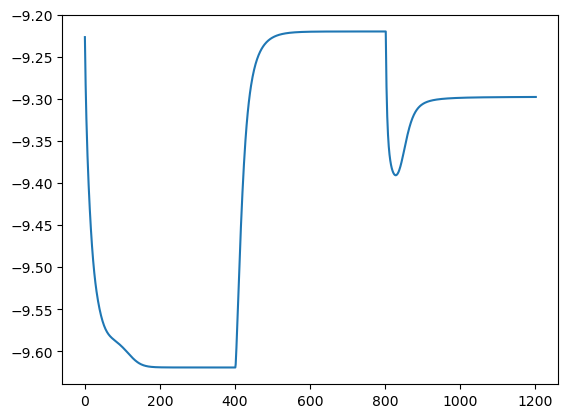

In [123]:
plt.plot(analytical_losses_i - losses)

SECOND ANALYTICAL FORGETTING FORMULA - FUNCTION OF THE CORRELATION MATRICES

In [104]:
anal = analyticals_list[0]
njp.anal - sigma_i

array([[-0.30742893, -0.28622777, -0.34549021, -0.64891389],
       [-0.66183451,  0.05887724,  0.13092295,  0.31962218],
       [-0.46555589, -0.0474195 ,  0.828535  , -0.60492755]])

NOT SURE WHY THIS DOESN'T WORK, WILL HAVE A LOOK

Text(0.5, 1.0, 'Empirical vs Analytical Forgetting')

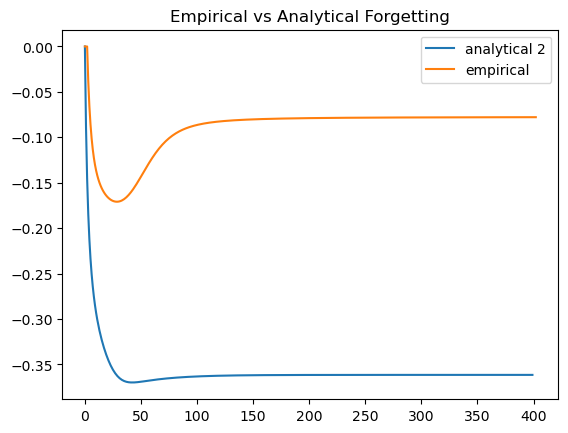

In [205]:
#this is just a function of the weights

sigma_i = analyticals_list[epochs*1]
sigma_j = analyticals_list[epochs*2]

forgetting_analytical_2 =  [0.5 *out_dim/ batch_size * (np.linalg.norm(anal - sigma_i, ord='fro')**2 - np.linalg.norm(sigma_j - sigma_i, ord='fro')**2) for anal in analyticals_list[epochs*2:]]

# forgetting_analytical_2
# plt.plot(forgetting_analytical_2)

plt.plot(forgetting_analytical_2, label='analytical 2')
plt.plot(forgetting_empirical, label='empirical')
plt.legend()
plt.title('Empirical vs Analytical Forgetting')


##implement this for unbalanced weights
#extend this to unbalanced 
#we have a derivation for forgetting in the unbalanced case

#if it does converge and it is full rank 
#only train on one example it can converge but many of the weights will be unused

#exact dynamics across time for forgetting

#in two layers you are guaranteed to converge 


## Step 4: Derive equation for Rate of Forgetting

Since $ F_i(T_j, T_k) = L_i(T_k) - L_i(T_j)$ depends on two loss functions, to find $\frac{d}{dt} F$ we first need to find $\frac{d}{dt} L$ of the Loss function. Given that we have exact learning dynamics for Balanced weights, we can find an explicit expression for the evolution of the loss in the balanced setting.

We start with the assumption that we have an expression for the evolution of the weights $W_2 W_1 (t)$ (which we do in the balanced case).


We already have results for $W_2 W_1 (t), \frac{d}{dt} W_2 W_1(t)$. These are the QQt equations. We have an expression for $QQ^T(t)$ for balanced weights. Another result from the appendix is that:

$\tau \frac{d}{dt} (Q Q^T) = F Q Q^T + Q Q^T F - (Q Q^T)^2$

WHAT IS $\tau$?? IT IS THE LEARNING RATE

With 

$$
F = \begin{bmatrix} 0 & (\tilde{\Sigma}^{yx})^T \\ \tilde{\Sigma}^{yx} & 0 \end{bmatrix}
$$

Reminder that 

$$
Q = \begin{bmatrix} W_1^T \\ W_2 \end{bmatrix}
$$

$$
Q Q^T = \begin{bmatrix} W_1^T W_1 & W_1^T W_2^T \\ W_2 W_1 & W_2 W_2^T \end{bmatrix}
$$

$$
\frac{d}{dt} Q Q^T = \begin{bmatrix} \frac{d}{dt}(W_1^T W_1) & \frac{d}{dt}(W_1^T W_2^T) \\ \frac{d}{dt}(W_2 W_1) & \frac{d}{dt}(W_2 W_2^T) \end{bmatrix}
$$




Hence we can now use this result to derive an expression for the rate of forgetting:

$F_i(T_j, T_k) = L_i(T_k) - L_i(T_j)$

Notice that $L_i(T_j)$ is a constant quantity while  L_i(T_k) changes through training, so we can write forgetting as a function of timesteps:

$F_i(T_j, T_k)(t) = L_i(T_k)(t) - L_i(T_j)$

Hence 

$\frac{d}{dt} F_i(T_j, T_k)(t) = \frac{d}{dt} L_i(T_k)(t)$

FORGETTING AND LOSS HAVE THE SAME GRADIENT

Definition of the Loss:

$L_i(t) = \frac{1}{2 P} || W_2 W_1(t) X_i - Y_i ||^2_{F}$

$= \frac{1}{2 P} Tr((W_2 W_1(t) X_i - Y_i) (W_2 W_1(t) X_i - Y_i)^T)$

Let $f(t) := W_2 W_1 (t)$ for simplicity. Then 

$L_i(t) = \frac{1} {2 P} Tr[f(t) f(t)^T] - \frac{1}{P} Tr[\tilde{\Sigma}_i^{yx} f(t)] + \frac{1}{2 P} Tr[Y_i Y_i^T]$

Hence

$\frac{d}{dt} L_i(t) = \frac{1} {2 P} \frac{d} {dt} Tr[f(t) f(t)^T] - \frac{1} {P} \frac{d} {dt} Tr[\tilde{\Sigma}_i^{yx} f(t)]$

$\frac{d} {dt} Tr[f(t) f(t)^T] = Tr[\frac{d} {dt} (f(t) f(t)^T)]$ by properties of Trace. 

$= Tr[f'(t) f(t)^T + f(t) f'(t)^T]$

$= 2 Tr[f(t) f'(t)^T]$ by properties of trace.

Similarly, 

$ \frac{d} {dt} Tr[\tilde{\Sigma}_i^{yx} f(t)]  = Tr[\frac{d} {dt} \tilde{\Sigma}_i^{yx} f(t)]$

$= Tr[\tilde{\Sigma}_i^{yx}  f'(t)]$

So: 

$L_i'(t) = \frac{1}{P} (Tr[f(t) f'(t)^T] - Tr[\tilde{\Sigma}_i^{yx}  f'(t)])$

$L_i'(t) = \frac{1}{P} Tr[(f(t) - \tilde{\Sigma}_i^{yx}) f'(t)]$

$L_i'(t) = \frac{1}{P} Tr[(W_2 W_1(t) - \tilde{\Sigma}_i^{yx}) W_2 W_1'(t)]$

## Step 4.1 Plot Rate of Loss Empirical + Analytical

## have a look at section 7.2 - Deep Network

## Step 4.2 Plot Rate of Forgetting Empirical + Analytical

## Step 5: Generate the following plots:
1. Plot showing that the dynamics and end representation should be the same (in both cases)
2. Plot showing the forgetting in the setting of delta is non zero
3. Plot showing the number of training epochs saved (number of eigenvectors in common, number of epochs saved, it should be linear algebra)
4. We can compute the rate of forgetting by computing the eigendecomposition in this case becasue our matrix is a block matrix. See Vidal (We could implement the solution up to the decomposition of O) in a relatively straightforward way. In both settings.
5. Compute te dynamics of learning

## Step 7: Optimal Stopping based on Task Similarity

formular la loss de las dos tareas combinadas $L_T$ total loss, eso te da un upper bound de como de bien puede aprender la red esas dos tareas. Volver al setup tipo forgetting. Entrenas T1 un rato, luego T2, en cada punto plotear la total loss, encontrar donde esta el punto minimo. Se llega al valor de OLS? El punto donde tienes el minimo es el punto de optimal stopping. Se puede calcular el punto de optimal stopping basado en la similitud de las dos tareas?

You have tasks $T_1 = (X_1, Y_1), T_2 = (X_2, Y_2)$. You have a linear network $\hat{Y}(t) = W_2 W_1(t) X$. The loss that we are trying to minimise is $L = \frac{1}{2 P} ||W_2 W_1(t) X - Y||_F^2$. 

Question is how much should we train on $T_1$ and $T_2$?. 

Simpler question: suppose we have already trained to $T_1$ to convergence. How much should we train on $T_2$ to minimise the overall loss?

This means $W_2 W_1 (0) = \Sigma_{1}^{yx}$. Idea: define the losses in terms of the correlation matrices, see how it evolves, see if we can find an optimum or at least simplify the equation. 


$ L_i(T_j) = \frac{1}{2 P} ||\tilde{\Sigma}^{yx}_j - \tilde{\Sigma}^{yx}_i||_F ^ 2 - \frac{1}{2 P} Tr((\tilde{\Sigma}^{yx}_i) (\tilde{\Sigma}^{yx}_i)^T) + \frac{1}{2P} Tr(\tilde{\Sigma}^{yy}_i)$

Epoch [10/400], Loss: 0.5203
Epoch [20/400], Loss: 0.3573
Epoch [30/400], Loss: 0.2636
Epoch [40/400], Loss: 0.2250
Epoch [50/400], Loss: 0.2152
Epoch [60/400], Loss: 0.2130
Epoch [70/400], Loss: 0.2125
Epoch [80/400], Loss: 0.2123
Epoch [90/400], Loss: 0.2123
Epoch [100/400], Loss: 0.2123
Epoch [110/400], Loss: 0.2123
Epoch [120/400], Loss: 0.2123
Epoch [130/400], Loss: 0.2123
Epoch [140/400], Loss: 0.2123
Epoch [150/400], Loss: 0.2123
Epoch [160/400], Loss: 0.2123
Epoch [170/400], Loss: 0.2123
Epoch [180/400], Loss: 0.2123
Epoch [190/400], Loss: 0.2123
Epoch [200/400], Loss: 0.2123
Epoch [210/400], Loss: 0.2123
Epoch [220/400], Loss: 0.2123
Epoch [230/400], Loss: 0.2123
Epoch [240/400], Loss: 0.2123
Epoch [250/400], Loss: 0.2123
Epoch [260/400], Loss: 0.2123
Epoch [270/400], Loss: 0.2123
Epoch [280/400], Loss: 0.2123
Epoch [290/400], Loss: 0.2123
Epoch [300/400], Loss: 0.2123
Epoch [310/400], Loss: 0.2123
Epoch [320/400], Loss: 0.2123
Epoch [330/400], Loss: 0.2123
Epoch [340/400], Lo

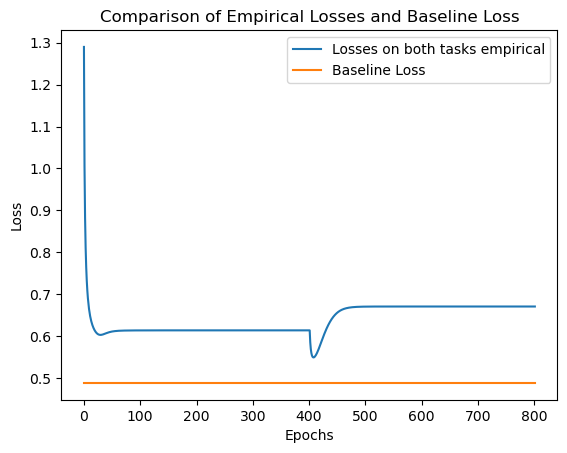

Index with the lowest loss: 408


ValueError: zero-size array to reduction operation minimum which has no identity

In [273]:
tau = 0.1
batch_size = 10
epochs = 400

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
init_w1 = torch.tensor(init_w1)
init_w2 = torch.tensor(init_w2)

model = LinearNetwork(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1, init_w2=init_w2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=tau)


X_1, Y_1 = get_random_regression_task(batch_size, in_dim, out_dim)
X_2, Y_2 = get_random_regression_task(batch_size, in_dim, out_dim)

# (X_1, Y_1) = (X_2, Y_2)

task_pair = [(X_1, Y_1), (X_2, Y_2)]

X_combined = np.concatenate((X_1, X_2))
Y_combined = np.concatenate((Y_1, Y_2))

# optimal loss baseline.
W2W1_baseline = np.linalg.inv((X_combined.T @ X_combined)) @ X_combined.T @ Y_combined

loss_baseline = 0.5 * out_dim / batch_size * np.linalg.norm((X_combined @ W2W1_baseline - Y_combined))

w1s_list = []
w2s_list = []

for (X, Y) in task_pair:
    w1s, w2s, _ = train(model, X_1, Y, criterion, optimizer, epochs)
    w1s_list.extend(w1s)
    w2s_list.extend(w2s)

w2w1s_list = [w2 @ w1 for (w2, w1) in zip(w2s_list, w1s_list)]

# print('weights: ', w2w1s_list[0].shape)
# print('x: ', X_combined.shape)
# print('y: ', Y_combined.shape)


losses_on_both_tasks_empirical = [0.5 * out_dim / batch_size * np.linalg.norm(X_combined @ w2w1.T - Y_combined) for w2w1 in w2w1s_list] 

# for i, (X, Y) in enumerate(tasks):
#     output_empirical = [X @ w2w1.T for w2w1 in w2w1s_list]
#     losses = [0.5 * out_dim / batch_size * np.linalg.norm(out - Y, ord='fro')**2 for out in output_empirical]
#     empirical_losses.append(losses)

# empirical_losses = torch.tensor(losses_list)


#1st step: have number of epochs against loss. train for 400 epochs on T1, then 400 epochs on T2 for example
loss_baseline = [loss_baseline] * len(losses_on_both_tasks_empirical)  # Repeat loss_baseline to match the length of losses_on_both_tasks_empirical

# Plotting
plt.plot(losses_on_both_tasks_empirical, label='Losses on both tasks empirical')
plt.plot(loss_baseline, label='Baseline Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Empirical Losses and Baseline Loss')
plt.legend()
plt.show()

index_min_loss = np.argmin(losses_on_both_tasks_empirical)

# Print the index with the lowest loss
print("Index with the lowest loss:", index_min_loss)

#2nd step: have a 3d graph showing #of epochs trained on T1 against number of epochs trained on T2 against loss
# loss_baseline

epochs_t1 = np.arange(0, epochs+1)
epochs_t2 = np.arange(0, epochs+1)

epochs_t1_mesh, epochs_t2_mesh = np.meshgrid(epochs_t1, epochs_t2)

losses_3d = np.zeros_like(epochs_t1_mesh, dtype=float)
for i in range(len(epochs_t1)):
    for j in range(len(epochs_t2)):
        w1s, w2s, _ = train(model, X_1, Y_1, criterion, optimizer, epochs_t1[i])
        _, _, losses = train(model, X_2, Y_2, criterion, optimizer, epochs_t2[j])
        losses_3d[i, j] = np.min(losses)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(epochs_t1_mesh, epochs_t2_mesh, losses_3d, cmap='viridis')
ax.set_xlabel('Epochs trained on Task 1')
ax.set_ylabel('Epochs trained on Task 2')
ax.set_zlabel('Loss')
ax.set_title('Loss Variation with Epochs Trained on Both Tasks')
plt.show()

##asumier que ya has entrenado en T1, sabemos lo que es W2W1 al principio. Cuanto podemos entrenar en T2 para que se minimice el overall loss?

##are the Xs whitened?

#assuming both of the tasks are whitened inputs, want to make comparison to joint distribution, only some cases they will have whitened inputs

## Prioritised Replay

viene de RL - deep Q network. 

un agente que va por un environment haciendo cosas. en cada step tienes una observacion. tienes que tomar una accion, recibes una recompensa/reward.netowrk predice: si tomo esta accion en este estado que recompensa tendre en el futuro? agente va tomando acciones en el environment

se guarda un buffer. contiene transiciones de state action reward. con este buffer se entrena la red neuronal. 

buffer muy grande de muchas State action reward - tienes que elegir d etodo tu buffer en cuales te viene mejor entrenar

en vez de sample randomly del buffer encontrar una manera mejor

reentrenar una memoria de la gente. se entrena la red neuronal en su propia memoria

no tiene que ser residual mas alto, tiene que ser que ayude mas al training. 

papers prioritised replay

calcula expected norm of the gradient, entrena tus dataopints, maximiza tu gradient para que te de alto. 

prioritised replay

Aunque las dos tareas tengan cierta similitud

A Linear network effectively performs linear regression on a task. Given two tasks $T_1, T_2$, The linear model that minimises the overall loss of the two tasks is linear regression on the combined dataset

$$\begin{bmatrix} T_1 \\ T_2 \end{bmatrix} $$

Let $(X_1, Y_1) = T_1, (X_2, Y_2 = T_2)$

The Linear Network model (as before is) $Y = W_2 W_1 X$

By Linear Regression we have $W_2 W_1 = (X^T X)^{-1} X^T Y$

Which is 

$$
W_2 W_1 = (\begin{bmatrix} X_1^T & X_2^T \end{bmatrix} \begin{bmatrix} X_1 \\ X_2 \end{bmatrix})^{-1}  \begin{bmatrix} X_1^T & X_2^T \end{bmatrix} \begin{bmatrix} Y_1 \\ Y_2 \end{bmatrix} 
$$


$$
W_2 W_1 = (\begin{bmatrix} )


$$
W_2 W_1 = (X_1^T X_1 + X_2^T X_2)^{-1} \begin{bmatrix} X_1^T & X_2^T \end{bmatrix}  \begin{bmatrix} Y_1 \\ Y_2 \end{bmatrix} 
$$

First Case: The tasks have the same singular values:

$X_1 = U_1 S V_1^T, X_2 = U_1 S V_2^T$

$X_1^T X_1 = V_1 S V_1^T, X_2^T X_2 = V_2 S V_2^T$

So 

$$
W_2 W_1 = (V_1 S V_1^T + V_2 S V_2^T)^{-1} \begin{bmatrix} V_1 S U_1^T & V_2 S U_2^T \end{bmatrix}  \begin{bmatrix} Y_1 \\ Y_2 \end{bmatrix} 
$$

$$
W_2 W_1 = ((V_1 + V_2) S (V_1^T + V_2^T))^{-1} \begin{bmatrix} V_1 S U_1^T & V_2 S U_2^T \end{bmatrix}  \begin{bmatrix} Y_1 \\ Y_2 \end{bmatrix} 
$$


Rotate second task into inputs from first task, then use the equations to solve. 

Keep certain eigenvectors and change the others. 

Assuming both tasks share the same Singular Vectors, try to understand the problem in that setting. Find t* where the loss is the smallest. Loss depends on difference between singular values. Solve for the t* that has the smallest loss across both tasks. 

singular values change, loss has to be a combo of diff that is evolving over time, how does this loss influence 

1. everything is aligned
2. assume changing one singular vector, quantify that by the # of singular vectors 
3. change number of singular vectors incrementally. 


Procrustes distance for task similarity. Manually remove some eigenvectors. Always start with most simple thing, then increase complexity. 

one singular vector, one singular value is a scalar equation. 

how do you know fit this into measuring your forgetting? 

X_1, X_2 are 1x1 only have one singular value, 1d singular vector. 

Use andrew's equation for temporal dynamics of singular value.

Second case: The task share some singular values:

WHAT DO WE LEARN ABOUT A DATASET? DO WE LEARN THE SINGULAR VECTORS OR SINGULAR VALUES?

DO SOMETHING WITH PRINCIPAL COMPONENT REGRESSION HERE

LOOK AT ANDREWS PAPER ABOUT HOW HE ROTATES THE WEIGHTS

## Step 6: Prioritised Replay

if you share some eigenvectors, you can free some weights. saving some epochs 

#number of epochs you need to reach convergence of the second task.

have a plot where u show that in the balanced weight the numerical simulation and numerical integration of Fukumizu equation match. do it this week. 

we don't know how to diagonalise but its a good step to show the equations sitll hold

it's hard to do diagonalisation
=> solve equations on scalar case
=> show what we can say on this setting about forgetting, generalisation and replay. 

optimal stopping poitn in the task aligned case

## generalistion - maybe we can figure out next week

zero-balanced weights => min norm solution

whenever you add noise to the weights, u can quantify how good your solution is to see if it converges again

how good is representation? how good at generalising?

have a loss. add noise to your weights. calculate loss again. 

how quickly does your loss

avg gradient of the loss at that point. 

how bad do thigns get messed up if we move in any direction.

assume noise is gaussian

how does loss scale with std of noise



## Step 7: Forgetting and Generalisation Performance.

1. scalar case for balanced weights

same approach as andrew. instead of a ssuming singular vals are the same you have a constant quantity. 

solution which is most robust to noise is minimum norm (zero balanced)

Fix all the things


### IMPLEMENTING ANALYTICAL SOLUTION